<a href="https://colab.research.google.com/github/zhukuixi/Pytorch_tutorial/blob/main/MNIST_tensorboard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import torchvision
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [105]:
batch_size=64

transform = transforms.Compose([transforms.ToTensor(),
                transforms.Normalize((0.1307,),(0.3081,))            
                 ])


train_dataset = datasets.MNIST(root="../dataset/mnist/",train=True,download=True,transform=transform)
train_loader = DataLoader(train_dataset,shuffle=True,batch_size=batch_size)

test_dataset = datasets.MNIST(root="../dataset/mnist/",train=False,download=True,transform=transform)
test_loader = DataLoader(test_dataset,shuffle=False,batch_size=batch_size)

classes=[0,1,2,3,4,5,6,7,8,9]

In [ ]:
# metric - accuracy
def accuracy(y_hat,y):
  #“==”opearation is sensitive to dype 
  # we need to do the dtype transformation before == operation
  if len(y_hat)>1 and y_hat.shape[1]>1:
      y_hat = y_hat.argmax(axis=1)
  return (y_hat.type(y.dtype)==y).sum()
  
class logisticNet(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = torch.nn.Flatten()
    self.linear = torch.nn.Linear(784,10)
  def forward(self,x):
    return torch.sigmoid(self.linear(self.flatten(x)))

net = logisticNet()


If the port is busy you can kill the PID occupied the port
In this example,6006 is the port number. After you type in the first command
, you can see the PID(11636 in this case)



In [102]:
#!lsof -i:6006
#!kill -9 16166

load the tensorboard  
**runs** here is the folder name storeing the logs

In [103]:
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 16166), started 1:42:38 ago. (Use '!kill 16166' to kill it.)

<IPython.core.display.Javascript object>

Create the SummaryWriter object

In [98]:
from torch.utils.tensorboard import SummaryWriter

# specify the output folder of log 
writer = SummaryWriter('runs/mnist_experiment_1')

In [76]:
# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img * 0.3081 + 0.1307      # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

Add some images to tensorboard

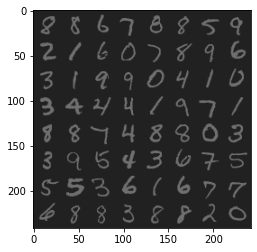

In [91]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=False)

# write to tensorboard
writer.add_image('One_batch_mnist_images', img_grid)

Add the network model to the tensorboard

In [78]:
writer.add_graph(net, images)


In [106]:
# helper functions

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [torch.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

In [ ]:


criterion = torch.nn.CrossEntropyLoss()
optimizier = torch.optim.SGD(net.parameters(),lr=0.1)

for epoch in np.arange(100):
  for i,data in enumerate(train_loader):
    X,y = data
    optimizier.zero_grad()
    y_hat = net(X)
    loss = criterion(y_hat, y)  
    loss.mean().backward()
    optimizier.step()
    print("{:.3}".format(loss.mean().item()))

    with torch.no_grad():
      acc = 0      
      count = 0 
      for X_test,y_test in test_loader:
        acc += accuracy(net(X_test),y_test)
        count += y_test.numel()
      print("test accuracy:{:.3}".format(acc/count))
    if i % 1000 == 999:    # every 1000 mini-batches...
      # ...log the running loss
      writer.add_scalar('training loss',
                      running_loss / 1000,
                      epoch * len(trainloader) + i)

      # ...log a Matplotlib Figure showing the model's predictions on a
      # random mini-batch
      writer.add_figure('predictions vs. actuals',
                      plot_classes_preds(net, inputs, labels),
                      global_step=epoch * len(trainloader) + i)
      running_loss = 0.0

